In [1]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import os
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from collections import Counter
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
# download dataset
api = KaggleApi()
api.authenticate()
api.dataset_download_files("shaunthesheep/microsoft-catsvsdogs-dataset")

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset


In [3]:
zip_file_path="microsoft-catsvsdogs-dataset.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("./DogsAndCatClasification")


In [4]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path) 
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
            images.append(img)
            labels.append(label)
    return images, labels


cat_images, cat_labels = load_images_from_folder("./DogsAndCatClasification/PetImages/Cat", 'cat')
dog_images, dog_labels = load_images_from_folder("./DogsAndCatClasification/PetImages/Dog", 'dog')

In [5]:
X = np.concatenate((cat_images, dog_images), axis=0)
y = np.concatenate((cat_labels, dog_labels), axis=0)

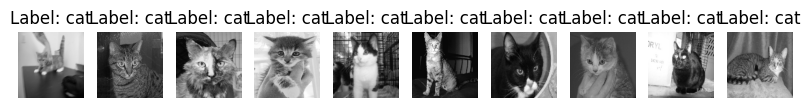

In [6]:
def show_samples(X, y, num_samples=5):
    plt.figure(figsize=(10, 2 * num_samples))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB))  
        plt.title(f"Label: {y[i]}")
        plt.axis("off")
    plt.show()

show_samples(X, y, num_samples=10)

In [7]:
#train_test_split default it shuffles the data before splitting
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [8]:
print(f'Train set: {len(X_train)} images')
print(f'Validation set: {len(X_val)} images')
print(f'Test set: {len(X_test)} images')

Train set: 19956 images
Validation set: 2495 images
Test set: 2495 images


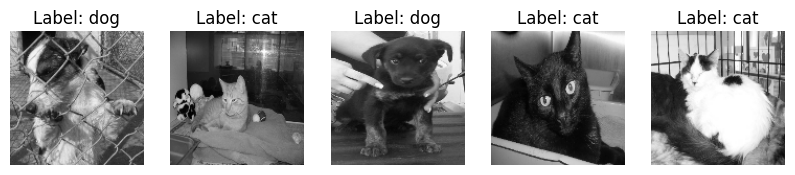

In [9]:
show_samples(X_train,y_train, num_samples=5)

In [10]:

train_counts = Counter(y_train)
print("Training set:")
print("  Cat:", train_counts['cat'])
print("  Dog:", train_counts['dog'])

val_counts = Counter(y_val)
print("Validation set:")
print("  Cat:", val_counts['cat'])
print("  Dog:", val_counts['dog'])

test_counts = Counter(y_test)
print("Test set:")
print("  Cat:", test_counts['cat'])
print("  Dog:", test_counts['dog'])

Training set:
  Cat: 9980
  Dog: 9976
Validation set:
  Cat: 1248
  Dog: 1247
Test set:
  Cat: 1248
  Dog: 1247


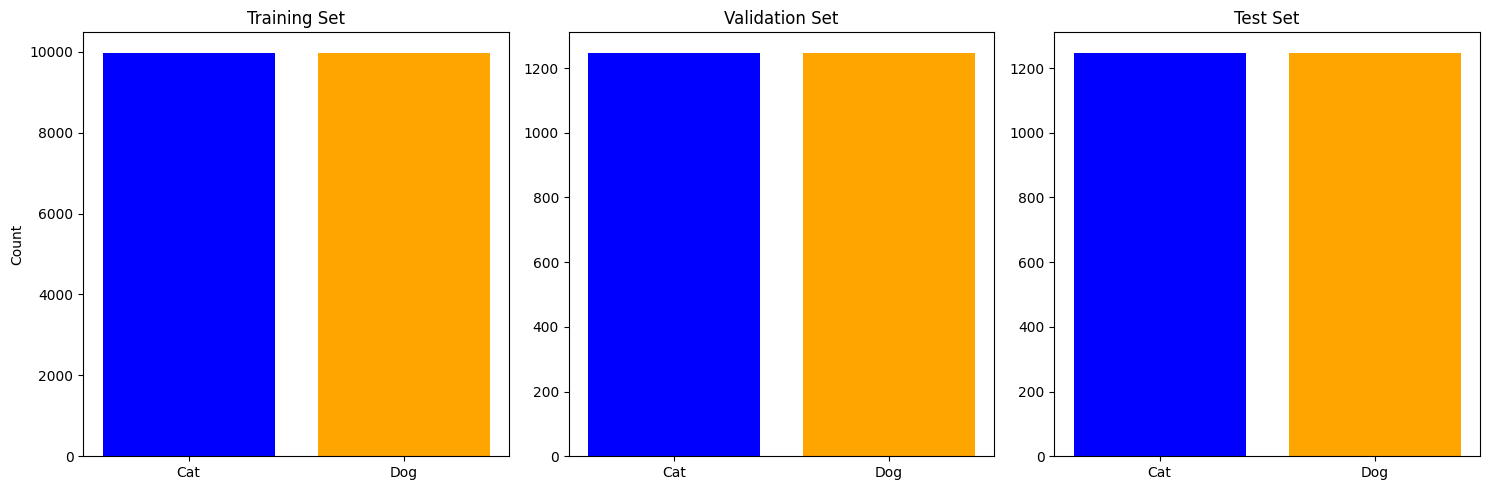

In [11]:
train_counts = Counter(y_train)
val_counts = Counter(y_val)
test_counts = Counter(y_test)


labels = ['Cat', 'Dog']
train_values = [train_counts['cat'], train_counts['dog']]
val_values = [val_counts['cat'], val_counts['dog']]
test_values = [test_counts['cat'], test_counts['dog']]


plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.bar(labels, train_values, color=['blue', 'orange'])
plt.title("Training Set")
plt.ylabel("Count")


plt.subplot(1, 3, 2)
plt.bar(labels, val_values, color=['blue', 'orange'])
plt.title("Validation Set")


plt.subplot(1, 3, 3)
plt.bar(labels, test_values, color=['blue', 'orange'])
plt.title("Test Set")


plt.tight_layout()
plt.show()

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.BatchNormalization(),

    # Wyjście
    tf.keras.layers.Dense(2, activation='softmax')
])

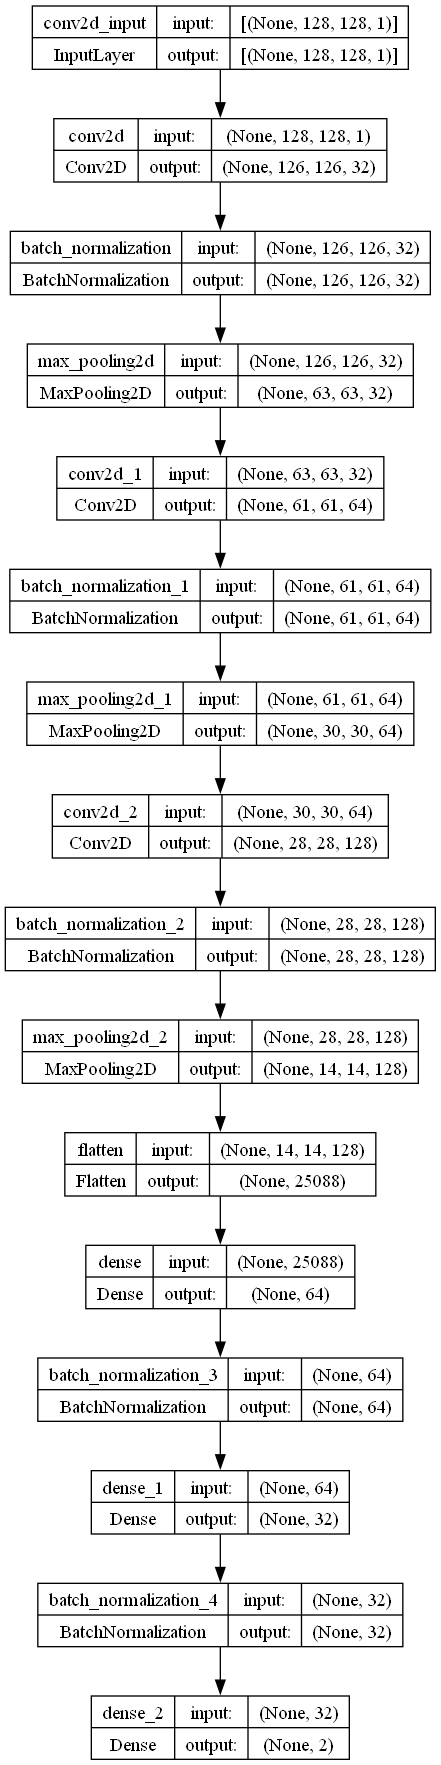

In [13]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
                                                        

In [15]:
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
encoder = LabelEncoder()


y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
624/624 [==============================] - 20s 17ms/step - loss: 0.6832 - accuracy: 0.6008 - val_loss: 0.7634 - val_accuracy: 0.5283
Epoch 2/10
624/624 [==============================] - 10s 16ms/step - loss: 0.6330 - accuracy: 0.6411 - val_loss: 0.6171 - val_accuracy: 0.6529
Epoch 3/10
624/624 [==============================] - 10s 16ms/step - loss: 0.5895 - accuracy: 0.6846 - val_loss: 0.7602 - val_accuracy: 0.5407
Epoch 4/10
624/624 [==============================] - 10s 16ms/step - loss: 0.5690 - accuracy: 0.7050 - val_loss: 0.8891 - val_accuracy: 0.5479
Epoch 5/10
624/624 [==============================] - 10s 16ms/step - loss: 0.5479 - accuracy: 0.7191 - val_loss: 0.8097 - val_accuracy: 0.5479
Epoch 6/10
624/624 [==============================] - 10s 16ms/step - loss: 0.5363 - accuracy: 0.7299 - val_loss: 0.7242 - val_accuracy: 0.5848
Epoch 7/10
624/624 [==============================] - 10s 16ms/step - loss: 0.5144 - accuracy: 0.7437 - val_loss: 1.1413 - val_accuracy:

In [16]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4)


In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit( X_train, y_train, epochs=70, batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_callback]  # Add callback 
)

Epoch 1/70
624/624 [==============================] - 12s 17ms/step - loss: 0.4768 - accuracy: 0.7714 - val_loss: 0.5757 - val_accuracy: 0.7102
Epoch 2/70
624/624 [==============================] - 10s 16ms/step - loss: 0.4699 - accuracy: 0.7738 - val_loss: 0.5843 - val_accuracy: 0.6790
Epoch 3/70
624/624 [==============================] - 10s 16ms/step - loss: 0.4671 - accuracy: 0.7784 - val_loss: 0.7401 - val_accuracy: 0.6325
Epoch 4/70
624/624 [==============================] - 10s 16ms/step - loss: 0.4594 - accuracy: 0.7843 - val_loss: 0.9541 - val_accuracy: 0.5451
Epoch 5/70
624/624 [==============================] - 10s 16ms/step - loss: 0.4450 - accuracy: 0.7937 - val_loss: 0.5186 - val_accuracy: 0.7463
Epoch 6/70
624/624 [==============================] - 10s 16ms/step - loss: 0.4387 - accuracy: 0.7956 - val_loss: 0.4448 - val_accuracy: 0.8040
Epoch 7/70
624/624 [==============================] - 10s 16ms/step - loss: 0.4246 - accuracy: 0.8040 - val_loss: 0.6434 - val_accuracy:

In [20]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit( X_train, y_train, epochs=70, batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_callback]  # Add callback 
)

Epoch 1/70
2495/2495 [==============================] - 21s 8ms/step - loss: 0.4557 - accuracy: 0.7843 - val_loss: 0.4831 - val_accuracy: 0.7663
Epoch 2/70
2495/2495 [==============================] - 19s 8ms/step - loss: 0.4343 - accuracy: 0.8003 - val_loss: 0.5281 - val_accuracy: 0.7403
Epoch 3/70
2495/2495 [==============================] - 19s 8ms/step - loss: 0.4274 - accuracy: 0.8010 - val_loss: 0.4241 - val_accuracy: 0.8108
Epoch 4/70
2495/2495 [==============================] - 19s 8ms/step - loss: 0.4250 - accuracy: 0.8057 - val_loss: 0.4664 - val_accuracy: 0.7760
Epoch 5/70
2495/2495 [==============================] - 20s 8ms/step - loss: 0.4246 - accuracy: 0.8085 - val_loss: 0.4592 - val_accuracy: 0.7804
Epoch 6/70
2495/2495 [==============================] - 21s 8ms/step - loss: 0.4094 - accuracy: 0.8157 - val_loss: 0.4817 - val_accuracy: 0.7711
Epoch 7/70
2495/2495 [==============================] - 21s 8ms/step - loss: 0.4190 - accuracy: 0.8095 - val_loss: 0.5626 - val_ac

In [22]:
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.3726
Test Accuracy: 0.8417
